# Cohort 7.3 AUCs ratios analysis

### Imports and environment setup

- Date of run: 2025-05-22
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import all functions from ../code/cohort_analysis_utils.py
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

# Data loading and preprosessing

## Samples data

In [4]:
df = pd.read_csv('../data/cohort_7.3_20250527.csv', sep='\t', index_col=0, header=0)

In [5]:
# Harmonization of column names
df_samples = utils.normalize_column_names(df)

In [6]:
df.head()

,Pathology,AGRIN,KPYM,MMP9,TIMP2,MVP,PERM,CLIC1,Total_protein,Endometrial_thickness,BMI
Sample_ID,,,,,,,,,,,
020-0174,Benigna,32.987278,187.484728,7.47,9.278291,92.309806,32.026415,381.131998,4.32,7.4,36.92
001-0195,Benigna,70.125611,251.618022,8.80,47.443599,69.047936,199.862000,264.465658,8.56,8.0,35.94
020-0057,Benigna,20.437714,136.706940,9.45,6.222567,63.799983,74.386205,204.698628,2.68,12.0,25.71
001-0025,Benigna,12.718849,NaN,9.62,3.686936,21.656366,125.117404,85.117851,1.07,2.0,25.00
032-0016,Benigna,44.614800,95.556240,11.20,9.220442,24.641575,116.829167,238.962236,1.11,5.0,NaN


In [7]:
df = utils.cols_as_category(df, {'Pathology':{'Benigna': 0, 'EC': 1}})

## Readouts

In [8]:
BIOMARKERS = ["MMP9", "KPYM", "AGRIN", "TIMP2", "MVP", "PERM", "CLIC1"]

# Model computation

## Compute ratios

In [9]:
for biomarker in BIOMARKERS:
    df[biomarker] =  pd.to_numeric(df[biomarker], errors='coerce')
    df[f'{biomarker}_log'] = np.log(df[biomarker] + 1)

In [10]:

# Create new columns with the ratios between the biomarkers
RATIOS_COLUMNS = []
for biomarker1 in BIOMARKERS:
    for biomarker2 in BIOMARKERS:
        if biomarker1 != biomarker2:
            df[f'{biomarker1}_{biomarker2}'] = df[f'{biomarker1}'] / df[f'{biomarker2}']
            # Make infinite values NaN
            df[f'{biomarker1}_{biomarker2}'] = df[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
            RATIOS_COLUMNS.append(f'{biomarker1}_{biomarker2}')
            
    

In [11]:
# Normalize the ratios
RATIOS_COLUMNS_NORM = []
for biomarker1 in BIOMARKERS:
    for biomarker2 in BIOMARKERS:
        if biomarker1 != biomarker2:
            #f = lambda x: np.log2(x[biomarker1]+1) / np.log2(x[biomarker2]+1) if x[biomarker2] != 0 else np.nan
            f = lambda x: np.log2((x[biomarker1] + 1e-6) / (x[biomarker2] + 1e-6)) if x[biomarker2] != 0 else np.nan
            #f = lambda x: (x[f'{biomarker1}_{biomarker2}'] - df[f'{biomarker1}_{biomarker2}'].mean()) / df[f'{biomarker1}_{biomarker2}'].std()
            df[f'{biomarker1}_{biomarker2}_norm'] = df.apply(f, axis=1)
            # Make infinite values NaN
            df[f'{biomarker1}_{biomarker2}_norm'] = df[f'{biomarker1}_{biomarker2}_norm'].replace([np.inf, -np.inf], np.nan)
            RATIOS_COLUMNS_NORM.append(f'{biomarker1}_{biomarker2}_norm')

In [12]:
df.columns

Index(['Pathology', 'AGRIN', 'KPYM', 'MMP9', 'TIMP2', 'MVP', 'PERM', 'CLIC1',
       'Total_protein', 'Endometrial_thickness',
       ...
       'PERM_AGRIN_norm', 'PERM_TIMP2_norm', 'PERM_MVP_norm',
       'PERM_CLIC1_norm', 'CLIC1_MMP9_norm', 'CLIC1_KPYM_norm',
       'CLIC1_AGRIN_norm', 'CLIC1_TIMP2_norm', 'CLIC1_MVP_norm',
       'CLIC1_PERM_norm'],
      dtype='object', length=102)

In [13]:
df.head()

,Pathology,AGRIN,KPYM,MMP9,TIMP2,MVP,PERM,CLIC1,Total_protein,Endometrial_thickness,...,PERM_AGRIN_norm,PERM_TIMP2_norm,PERM_MVP_norm,PERM_CLIC1_norm,CLIC1_MMP9_norm,CLIC1_KPYM_norm,CLIC1_AGRIN_norm,CLIC1_TIMP2_norm,CLIC1_MVP_norm,CLIC1_PERM_norm
Sample_ID,,,,,,,,,,,,,,,,,,,,,
020-0174,0,32.987278,187.484728,7.47,9.278291,92.309806,32.026415,381.131998,4.32,7.4,...,-0.042647,1.787331,-1.527222,-3.572956,5.673038,1.023518,3.530309,5.360288,2.045735,3.572956
001-0195,0,70.125611,251.618022,8.80,47.443599,69.047936,199.862000,264.465658,8.56,8.0,...,1.510991,2.074719,1.533334,-0.404076,4.909433,0.071845,1.915067,2.478795,1.937410,0.404076
020-0057,0,20.437714,136.706940,9.45,6.222567,63.799983,74.386205,204.698628,2.68,12.0,...,1.863801,3.579453,0.221479,-1.460394,4.437043,0.582415,3.324196,5.039848,1.681873,1.460394
001-0025,0,12.718849,NaN,9.62,3.686936,21.656366,125.117404,85.117851,1.07,2.0,...,3.298242,5.084716,2.530419,0.555749,3.145353,NaN,2.742493,4.528967,1.974671,-0.555749
032-0016,0,44.614800,95.556240,11.20,9.220442,24.641575,116.829167,238.962236,1.11,5.0,...,1.388806,3.663421,2.245234,-1.032382,4.415212,1.322361,2.421188,4.695803,3.277616,1.032382


In [14]:
# Create new columns with Endometrial_thickness binary as >3, >4, >5, and as an integer
# df['Endometrial_thickness'] = df['Endometrial_thickness'].replace([np.inf, -np.inf], np.nan)
# df['Endometrial_thickness'] = df['Endometrial_thickness'].astype(float)
# df['Endometrial_thickness_binary_3'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 3 else 0)
# df['Endometrial_thickness_binary_4'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 4 else 0)
# df['Endometrial_thickness_binary_5'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 5 else 0)
# df['Endometrial_thickness_binary_6'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 6 else 0)
# df['Endometrial_thickness_binary_7'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 7 else 0)
# df['Endometrial_thickness_binary_8'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 8 else 0)
# df['Endometrial_thickness_binary_9'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 9 else 0)
# df['Endometrial_thickness_binary_10'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 10 else 0)
# df['Endometrial_thickness_binary_11'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 11 else 0)
# df['Endometrial_thickness_binary_12'] = df['Endometrial_thickness'].apply(lambda x: 1 if x > 12 else 0)

# df['Endometrial_thickness_integer'] = df['Endometrial_thickness'].apply(lambda x: int(x) if x > 0 else 0)

# ET_COLUMNS = ['Endometrial_thickness', 'Endometrial_thickness_binary_3', 'Endometrial_thickness_binary_4', 'Endometrial_thickness_binary_5', 'Endometrial_thickness_integer']
# ET_COLUMNS += [f'Endometrial_thickness_binary_{i}' for i in range(6, 13)]


In [15]:
df['Endometrial_thickness'] = df['Endometrial_thickness'].astype(float)
#df['BMI'] = df['BMI'].astype(float)


## Models creation

In [16]:
# RESULTS_PATH = f'../data/results/cohort_7_3/ratios_et/'
# apply_log = False
# NORMALIZING_COL = '' 
# VOLUME_COL = ''
# METHODS = ['direct']

# for biomarker_count in range(1, 4):
#     #results_path_complete = f'{RESULTS_PATH}log_{apply_log}/'

#     print(f'Number of biomarkers: {biomarker_count}')
#     #print(results_path_complete)
#     models = utils.compute_all_models_and_save(
#                                 df=df,
#                                 biomarkers=['Endometrial_thickness'] + RATIOS_COLUMNS_NORM,
#                                 normalizing_col=NORMALIZING_COL, 
#                                 volume_col= VOLUME_COL,
#                                 volume_added=0.5,
#                                 apply_log=apply_log,
#                                 avoid_same_biomarker=True,
#                                 methods=METHODS,
#                                 max_biomarker_count=biomarker_count,
#                                 folder_name=RESULTS_PATH,
#                                 plot_rocs=True if biomarker_count < 3 else False,
#                                 auc_threshold=0.5 + 0.4 * (biomarker_count > 1),
#                                 compute_auc_ci=True if biomarker_count == 1 else False,
#                                 )

#     if biomarker_count == 1:
#         # Reserve the models with confidence intervals for the final analysis
#         models_with_auc_ci = models
    
#     print(f'Number of biomarkers: {biomarker_count} done')


In [17]:
# import math

# ratio_pairs = [(b1, b2) for b1 in BIOMARKERS for b2 in BIOMARKERS if b1 != b2]
# n_plots = len(ratio_pairs)
# n_cols = 3
# n_rows = math.ceil(n_plots / n_cols)

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
# axes = axes.flatten()

# for idx, (biomarker1, biomarker2) in enumerate(ratio_pairs):
#     ax = axes[idx]
#     col_name = f'{biomarker1}_{biomarker2}'
#     # Create a single violin split by pathology
#     sns.violinplot(
#         data=df,
#         x=[f'{biomarker1}/{biomarker2}'] * len(df),  # single category
#         y=col_name,
#         hue='Pathology',
#         split=True,
#         ax=ax,
#         inner='box'
#     )
#     ax.set_title(f'{biomarker1}/{biomarker2} ratio by pathology')
#     ax.set_xlabel('')
#     ax.set_ylabel(f'{biomarker1}/{biomarker2} ratio')
#     ax.legend(title='Pathology')

# # Hide any unused subplots
# for idx in range(n_plots, len(axes)):
#     fig.delaxes(axes[idx])

# plt.tight_layout()
# plt.show()

### Normalized by total protein

In [18]:
# RESULTS_PATH = f'../data/results/cohort_7_3/tp/'
# NORMALIZING_COL = 'Total_protein' 
# methods = ['normalize']

# for biomarker_count in range(1, 4):
#     for apply_log in [True, False]:
#         results_path_complete = f'{RESULTS_PATH}log_{apply_log}/'

#         print(f'Number of biomarkers: {biomarker_count}')

#         models = utils.compute_all_models_and_save(
#                                     df=df,
#                                     biomarkers=BIOMARKERS,
#                                     normalizing_col=NORMALIZING_COL, 
#                                     volume_col= VOLUME_COL,
#                                     volume_added=0.5,
#                                     apply_log=apply_log,
#                                     avoid_same_biomarker=True,
#                                     methods=METHODS,
#                                     max_biomarker_count=biomarker_count,
#                                     folder_name=results_path_complete,
#                                     plot_rocs=True,
#                                     auc_threshold=0.5 + 0.1 * biomarker_count,
#                                     compute_auc_ci=True if biomarker_count == 1 else False,
#                                     )

#         if biomarker_count == 1:
#             # Reserve the models with confidence intervals for the final analysis
#             models_with_auc_ci = models
        
#         print(f'Number of biomarkers: {biomarker_count} done')


# Validation within other cohorts

In [19]:
df['AGRIN_TIMP2_eps'] = ((df['AGRIN'] + 1e-6) / (df['TIMP2'] + 1e-6)).apply(lambda x: np.log2(x) if x > 0 else np.nan)
df['AGRIN_TIMP2_eps'] = df['AGRIN_TIMP2_eps'].replace([np.inf, -np.inf], np.nan)
df['AGRIN_TIMP2_eps'] = df['AGRIN_TIMP2_eps'].astype(float)

In [20]:
RESULTS_PATH = f'../data/results/cohort_7_3/borrar/'
apply_log = False
NORMALIZING_COL = '' 
VOLUME_COL = ''
METHODS = ['direct']

for biomarker_count in [1,2]: #range(2, 4):
    for apply_log in [False]:
        print(f'Number of biomarkers: {biomarker_count}')
        models = utils.compute_all_models_and_save(
                                    df=df,
                                    biomarkers=['Endometrial_thickness', 'AGRIN_TIMP2_eps'],
                                    normalizing_col=NORMALIZING_COL, 
                                    volume_col= VOLUME_COL,
                                    volume_added=0.5,
                                    apply_log=apply_log,
                                    avoid_same_biomarker=True,
                                    methods=METHODS,
                                    max_biomarker_count=biomarker_count,
                                    folder_name=RESULTS_PATH,
                                    plot_rocs=True,
                                    auc_threshold=0.4 + 0.1 * biomarker_count,
                                    compute_auc_ci=True if biomarker_count == 1 else False,
                                    )

        if biomarker_count == 1:
            # Reserve the models with confidence intervals for the final analysis
            models_with_auc_ci = models
        
        print(f'Number of biomarkers: {biomarker_count} done')


Number of biomarkers: 1


Number of biomarkers: 1 done
Number of biomarkers: 2
Number of biomarkers: 2 done


In [21]:
model = models["direct"]['Endometrial_thickness_AGRIN_TIMP2_eps'][('Endometrial_thickness', 'AGRIN_TIMP2_eps')]['model']

#### Cohort 240

In [22]:
df_240 = pd.read_csv('../data/ruo_240_11bmk_20250225.csv', sep='\t', index_col=0, header=0)
df_240 = utils.normalize_column_names(df_240)
# Ensure numeric columns are treated as such
cols_240_to_num = ['Total_protein',
                   'HSPB1', 'MDK', 'MMP9','OSTP', 'PERM',
                    'AGRIN', 'NGAL','MVP', 'FABP5',
                    'PIGR', 'MIF'] # 'BCAM',
df_240 = utils.cols_as_numbers(df_240, cols_240_to_num)
df_240 = utils.cols_as_category(df_240, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})


In [23]:
df_240['Endometrial_thickness'] = pd.read_csv('../data/ruo_240_11bmk_20250201.csv', sep='\t', index_col=0, header=0).grosor_endometrial_eco_mm


In [24]:
df_240['TIMP2'] = pd.read_csv('../data/mmk_240_TIMP_ADIPOQ_20250217.csv', sep='\t', index_col=0, header=0)['TIMP-2']

In [25]:
df_240['AGRIN_TIMP2_eps'] = ((df_240['AGRIN'] + 1e-6) / (df_240['TIMP2'] + 1e-6)).apply(lambda x: np.log2(x) if x > 0 else np.nan)
df_240['AGRIN_TIMP2_eps'] = df_240['AGRIN_TIMP2_eps'].replace([np.inf, -np.inf], np.nan)
df_240['AGRIN_TIMP2_eps'] = df_240['AGRIN_TIMP2_eps'].astype(float)
df_240['Endometrial_thickness'] = df_240['Endometrial_thickness'].replace([np.inf, -np.inf], np.nan)
df_240['Endometrial_thickness'] = df_240['Endometrial_thickness'].astype(float)

In [26]:
df_240.dropna(subset=['Endometrial_thickness', 'AGRIN_TIMP2_eps'], inplace=True)

In [27]:
df_240_clean = df_240[['Pathology', 'Endometrial_thickness', 'AGRIN_TIMP2_eps', 'AGRIN', 'TIMP2']]

In [28]:
X = sm.add_constant(df_240_clean[['Endometrial_thickness', 'AGRIN_TIMP2_eps']], has_constant='add')
df_240_clean['Pathology_pred'] = model.predict(X)

In [29]:
df_240_clean.Pathology.value_counts()

Pathology
1    34
Name: count, dtype: int64

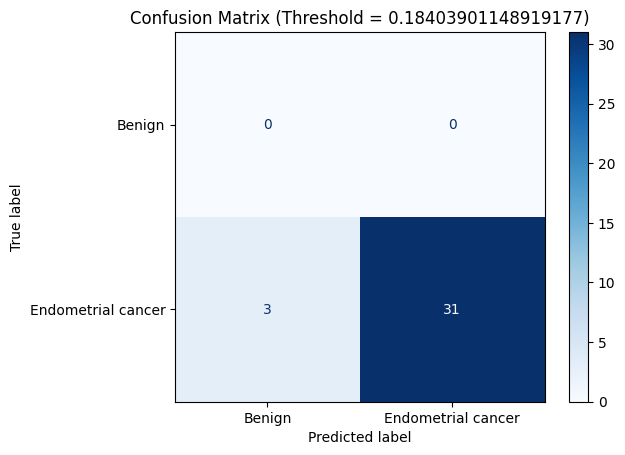

Sensitivity: 0.9117647058823529
Specificity: nan


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Set your custom threshold
threshold_around_95 = 0.20465979189004901 # 0.21311055033534845
threshold_95 = 0.18403901148919177 # 0.20029256263255865
threshold_97 = 0.14400778798706673 # 0.13149873423913339

# Apply threshold manually
df_240_clean['Pathology_pred_class'] = (df_240_clean['Pathology_pred'] <= threshold_95).astype(int)

# Create the confusion matrix
cm = confusion_matrix(
    df_240_clean['Pathology'], 
    df_240_clean['Pathology_pred_class'], 
    labels=[0, 1]
)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Endometrial cancer'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix (Threshold = {threshold_95})')
plt.show()

print(f'Sensitivity: {cm[1, 1] / (cm[1, 1] + cm[1, 0])}')
print(f'Specificity: {cm[0, 0] / (cm[0, 0] + cm[0, 1])}')


#### Cohort 7.1

In [31]:
df_152 = pd.read_csv('../data/60x60_dr_mmk_20250224.csv' , sep='\t', index_col=0, header=0)
df_152 = df_152[['Pathology']]
df_152 = utils.cols_as_category(df_152, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

for biomarker in ["AGRIN","TIMP2","KPYM"]:
    df_readouts = pd.read_excel("../data/152_20250423.xlsx", sheet_name=biomarker, header=0, index_col=0)
    df_readouts = utils.normalize_column_names(df_readouts)
    df_readouts = df_readouts.rename(columns={'Repeat': f'Repeat_{biomarker}'})
    # merge with df_samples
    df_152 = pd.merge(df_152, df_readouts, left_index=True, right_index=True, how='left')

In [32]:
df_152['Endometrial_thickness'] = pd.read_csv('../data/cohort_7.1_ET.csv', sep='\t', index_col=0, header=0).Endometrial_thickness

In [33]:
df_152['AGRIN'] = pd.to_numeric(df_152['AGRIN_G1_repeats'].replace([np.inf, -np.inf], np.nan), errors='coerce')
df_152['TIMP2'] = pd.to_numeric(df_152['TIMP2_G1_repeats'].replace([np.inf, -np.inf], np.nan), errors='coerce')
df_152['KPYM'] = pd.to_numeric(df_152['KPYM_G1_repeats'].replace([np.inf, -np.inf], np.nan), errors='coerce')
df_152['AGRIN_TIMP2_eps'] = ((df_152['AGRIN'] + 1e-6) / (df_152['TIMP2'] + 1e-6)).apply(lambda x: np.log2(x) if x > 0 else np.nan)
df_152['Endometrial_thickness'] = pd.to_numeric(df_152['Endometrial_thickness'], errors='coerce')
df_152 = df_152[['Pathology', 'AGRIN', 'TIMP2','KPYM', 'AGRIN_TIMP2_eps', 'Endometrial_thickness']]
df_152.dropna(subset=['Endometrial_thickness', 'AGRIN_TIMP2_eps'], inplace=True)


In [34]:
X = sm.add_constant(df_152[['Endometrial_thickness', 'AGRIN_TIMP2_eps']], has_constant='add')
df_152['Pathology_pred'] = model.predict(X)

In [35]:
df_152.dropna(subset=['Endometrial_thickness', 'AGRIN_TIMP2_eps'], inplace=True)

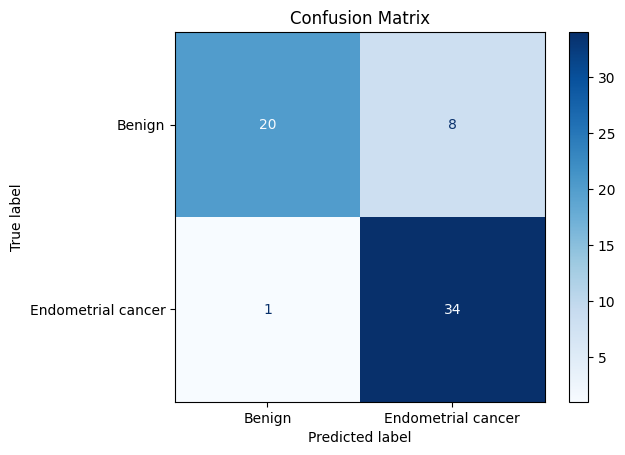

Sensitivity: 0.9714285714285714
Specificity: 0.7142857142857143
NPV: 0.9523809523809523


In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Apply threshold manually
df_152['Pathology_pred_class'] = (df_152['Pathology_pred'] > 0.84-threshold_95).astype(int)

# Create the confusion matrix
cm = confusion_matrix(
    df_152['Pathology'], 
    df_152['Pathology_pred_class'], 
    labels=[0, 1]
)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Endometrial cancer'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix')
plt.show()

print(f'Sensitivity: {cm[1, 1] / (cm[1, 1] + cm[1, 0])}')
print(f'Specificity: {cm[0, 0] / (cm[0, 0] + cm[0, 1])}')
print(f'NPV: {(cm[0, 0]) / (cm[0, 0] + cm[1, 0])}')

### Cohort 2mL

In [38]:
df_2mL = pd.read_csv('../data/2mL_20250220.csv' , sep='\t', index_col=0, header=0)
df_2mL = utils.normalize_column_names(df_2mL)
df_2mL = df_2mL[['Pathology', 'AGRIN', 'TIMP2', 'KPYM']]
# Remove zeros from AGRIN and TIMP-2
df_2mL = df_2mL[(df_2mL['AGRIN'] != 0) & (df_2mL['TIMP2'] != 0)]
# Rename TIMP-2 to TIMP2
df_2mL = df_2mL.rename(columns={'TIMP-2': 'TIMP2'})
df_2mL = utils.cols_as_numbers(df_2mL, ['AGRIN', 'TIMP2'])
df_2mL = utils.cols_as_category(df_2mL, {'Pathology':{
                                            'Benigna': 0, 
                                            'Adenocarcinoma de endometrio': 1,
                                            'Otros': np.nan,
                                            'Hiperplasia atípica endometrial': np.nan,
                                        }})
df_2mL.dropna(inplace=True)

In [39]:
df_2mL['Endometrial_thickness'] = pd.read_csv('../data/2mL_ET.csv', sep='\t', index_col=0, header=0).Endometrial_thickness

In [40]:
df_2mL['AGRIN_TIMP2_eps'] = ((df_2mL['AGRIN'] + 1e-6) / (df_2mL['TIMP2'] + 1e-6)).apply(lambda x: np.log2(x) if x > 0 else np.nan)
df_2mL['Endometrial_thickness'] = pd.to_numeric(df_2mL['Endometrial_thickness'], errors='coerce')
df_2mL = df_2mL[['Pathology', 'AGRIN', 'TIMP2','KPYM', 'AGRIN_TIMP2_eps', 'Endometrial_thickness']]
df_2mL.dropna(subset=['Endometrial_thickness', 'AGRIN_TIMP2_eps'], inplace=True)


In [41]:
X = sm.add_constant(df_2mL[['Endometrial_thickness', 'AGRIN_TIMP2_eps']], has_constant='add')
df_2mL['Pathology_pred'] = model.predict(X)

In [69]:
threshold_95+0.33

0.5140390114891917

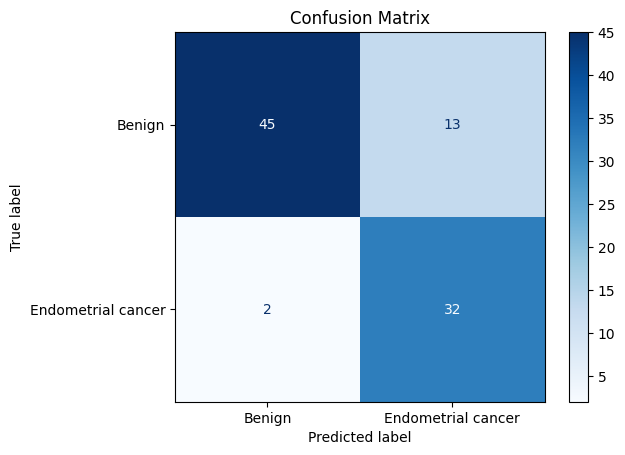

Sensitivity: 0.9411764705882353
Specificity: 0.7758620689655172
NPV: 0.9574468085106383


In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Apply threshold manually
df_2mL['Pathology_pred_class'] = (df_2mL['Pathology_pred'] > 0.5).astype(int)

# Create the confusion matrix
cm = confusion_matrix(
    df_2mL['Pathology'], 
    df_2mL['Pathology_pred_class'], 
    labels=[0, 1]
)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Endometrial cancer'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix')
plt.show()

print(f'Sensitivity: {cm[1, 1] / (cm[1, 1] + cm[1, 0])}')
print(f'Specificity: {cm[0, 0] / (cm[0, 0] + cm[0, 1])}')
print(f'NPV: {(cm[0, 0]) / (cm[0, 0] + cm[1, 0])}')

#### ScreenEC

In [43]:
df_screenEC = pd.read_csv('../data/screenec.csv', index_col=0, header=0, sep='\t')
df_screenEC = utils.normalize_column_names(df_screenEC)
df_screenEC['AGRIN'] = df_screenEC['AGRN_ng/mg'].astype('float')
df_screenEC['TIMP2'] = df_screenEC['TIMP2_ng/mg'].astype('float')
df_screenEC['Endometrial_thickness'] = df_screenEC['Grosor_endometrial'].astype('float')
df_screenEC['Pathology'] = df_screenEC['DX']

df_screenEC = utils.cols_as_category(df_screenEC, {'Pathology':{'non-EC': 0, 'EC': 1}})
df_screenEC = df_screenEC[['AGRIN', 'TIMP2', 'Endometrial_thickness', 'Pathology']]
df_screenEC = df_screenEC.dropna()

df_screenEC['AGRIN_TIMP2_eps'] = ((df_screenEC['AGRIN'] + 1e-6) / (df_screenEC['TIMP2'] + 1e-6)).apply(lambda x: np.log2(x) if x > 0 else np.nan)


In [44]:
X = sm.add_constant(df_screenEC[['Endometrial_thickness', 'AGRIN_TIMP2_eps']], has_constant='add')
df_screenEC['Pathology_pred'] = model.predict(X)

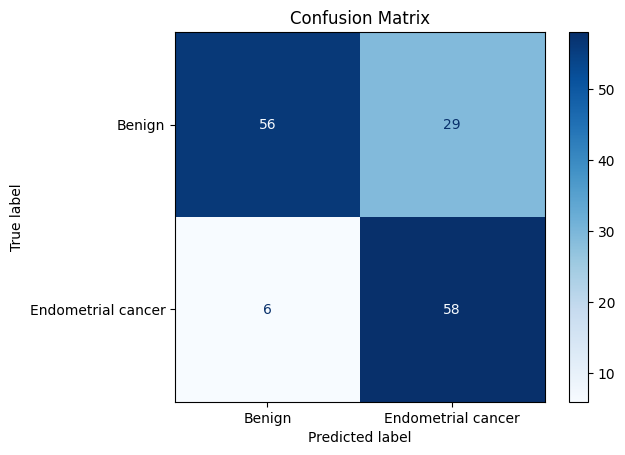

Sensitivity: 0.90625
Specificity: 0.6588235294117647
NPV: 0.9032258064516129


In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Apply threshold manually
df_screenEC['Pathology_pred_class'] = (df_screenEC['Pathology_pred'] > 0.01).astype(int)

# Create the confusion matrix
cm = confusion_matrix(
    df_screenEC['Pathology'], 
    df_screenEC['Pathology_pred_class'], 
    labels=[0, 1]
)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Endometrial cancer'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix')
plt.show()

print(f'Sensitivity: {cm[1, 1] / (cm[1, 1] + cm[1, 0])}')
print(f'Specificity: {cm[0, 0] / (cm[0, 0] + cm[0, 1])}')
print(f'NPV: {(cm[0, 0]) / (cm[0, 0] + cm[1, 0])}')

## Plotting results

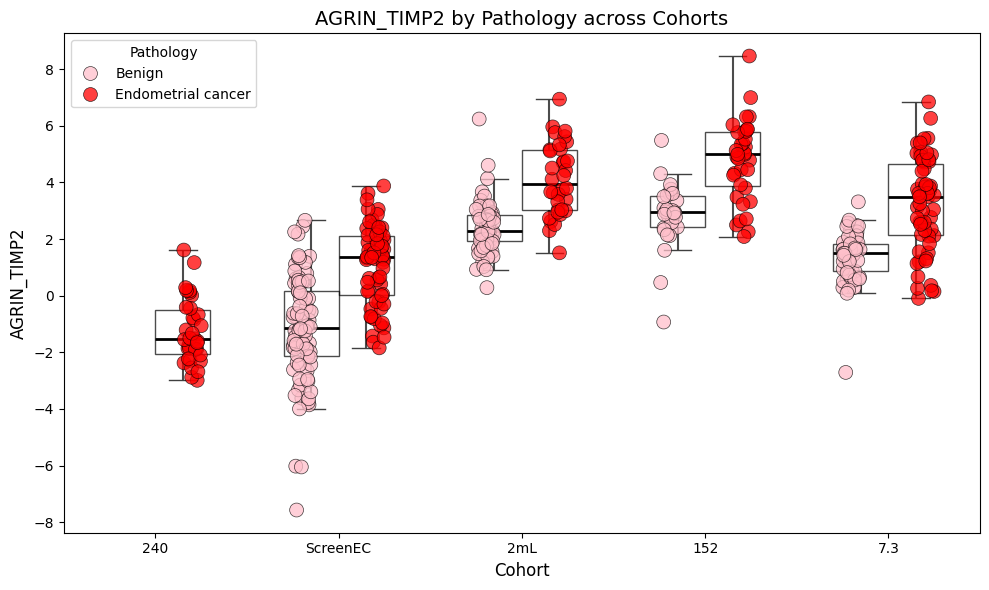

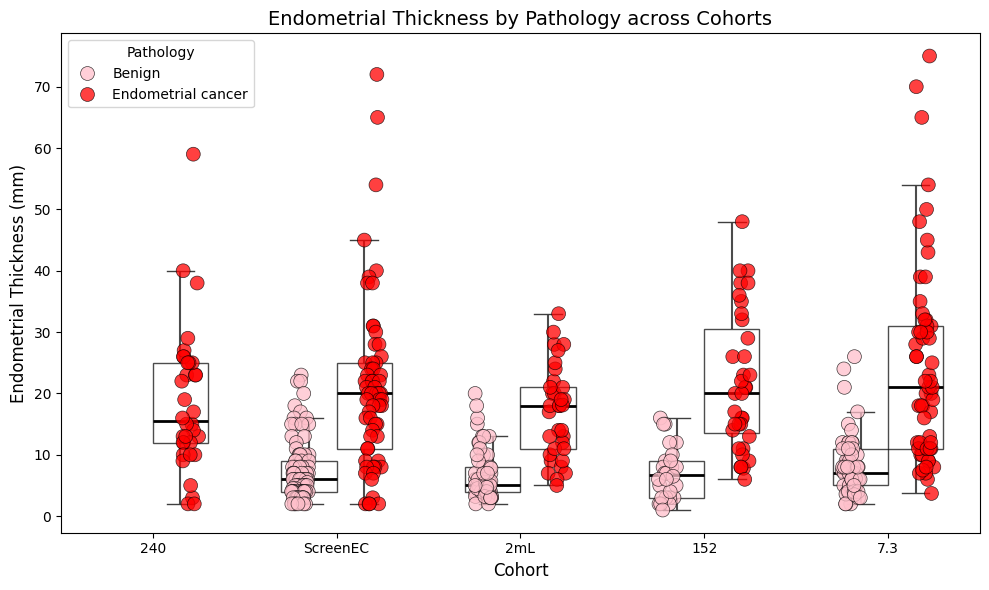

In [46]:
def plot_variable_by_cohort_pathology(combined_df, variable_name, 
                                      title=None, y_label=None, 
                                      figsize=(10, 6), ylim=None, 
                                      yscale='linear'):
    """
    Creates a combined stripplot and boxplot visualization for any variable
    across cohorts and pathology groups.
    
    Parameters:
    -----------
    combined_df : pandas DataFrame
        The combined dataframe with 'Cohort' and 'Pathology' columns
    variable_name : str
        The name of the variable to plot on y-axis
    title : str, optional
        The title for the plot
    y_label : str, optional
        The y-axis label
    figsize : tuple, optional
        Figure size as (width, height)
    ylim : tuple, optional
        Y-axis limits as (min, max)
    """
    # Create a single figure
    plt.figure(figsize=figsize)
    
    # First create the stripplot
    ax = sns.stripplot(data=combined_df, x='Cohort', y=variable_name, 
                 hue='Pathology', dodge=True, jitter=True, alpha=0.75, 
                 palette={0: 'pink', 1: 'red'}, 
                 marker='o', size=10,
                 edgecolor='black', linewidth=0.5)
    
    # Then add boxplot on top with transparent boxes
    sns.boxplot(data=combined_df, x='Cohort', y=variable_name, 
                hue='Pathology', dodge=True,
                boxprops={'facecolor': 'none', 'edgecolor': 'black', 'alpha': 0.7},
                width=0.6, 
                whiskerprops={'linewidth': 1.5, 'color': 'black', 'alpha': 0.7},
                medianprops={'linewidth': 2, 'color': 'black'},
                showfliers=False, ax=ax)
    
    # Get the legend from the first plot and remove it
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    
    # Create a single legend for both plots
    plt.legend(handles[:2], ['Benign', 'Endometrial cancer'], title='Pathology')
    
    # Add title and labels
    if title is None:
        title = f'{variable_name} by Pathology across Cohorts'
    plt.title(title, fontsize=14)
    
    plt.xlabel('Cohort', fontsize=12)
    
    if y_label is None:
        y_label = variable_name
    plt.ylabel(y_label, fontsize=12)
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)

    # Set y-axis scale
    if yscale == 'log':
        plt.yscale('log')
    elif yscale == 'linear':
        plt.yscale('linear')
    
    # Add a horizontal line at y=0 for reference
    #plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# First, prepare the combined dataframe
df_240_clean['Cohort'] = '240'
df_240['Cohort'] = '240'
df_152['Cohort'] = '152'
df['Cohort'] = '7.3'
df_2mL['Cohort'] = '2mL'
df_screenEC['Cohort'] = 'ScreenEC'
#combined_df = pd.concat([df_240_clean, df_screenEC, df_2mL, df_152, df], ignore_index=True)
combined_df = pd.concat([df_240, df_screenEC, df_2mL, df_152, df], ignore_index=True)

# Example usage for AGRIN_TIMP2_eps
plot_variable_by_cohort_pathology(
    combined_df=combined_df,
    variable_name='AGRIN_TIMP2_eps',
    y_label='AGRIN_TIMP2',
    title='AGRIN_TIMP2 by Pathology across Cohorts',
    #yscale='log',
)

# Example usage for Endometrial_thickness
plot_variable_by_cohort_pathology(
    combined_df=combined_df,
    variable_name='Endometrial_thickness',
    y_label='Endometrial Thickness (mm)',
    title='Endometrial Thickness by Pathology across Cohorts'
)

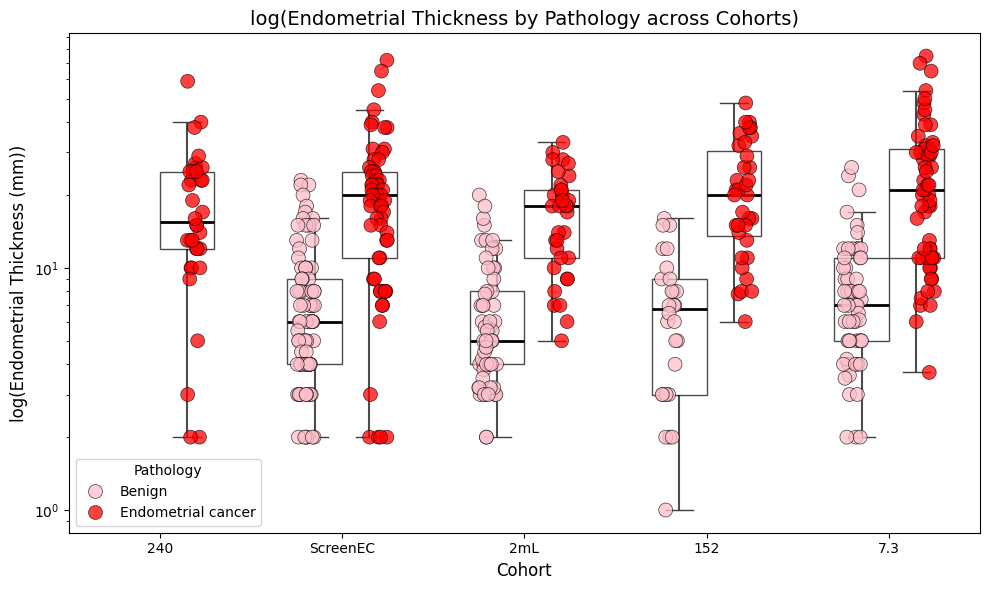

In [47]:
# Example usage for Endometrial_thickness
plot_variable_by_cohort_pathology(
    combined_df=combined_df,
    variable_name='Endometrial_thickness',
    y_label='log(Endometrial Thickness (mm))',
    title='log(Endometrial Thickness by Pathology across Cohorts)',
    yscale='log',
)

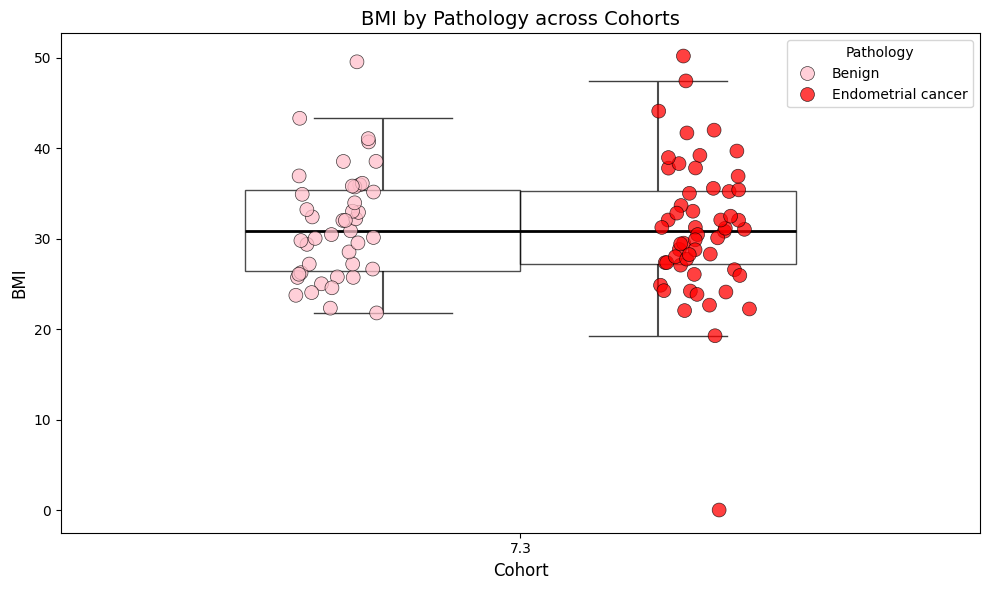

In [48]:
# Example usage for Endometrial_thickness
plot_variable_by_cohort_pathology(
    combined_df=df,
    variable_name='BMI',
    y_label='BMI',
    title='BMI by Pathology across Cohorts'
)

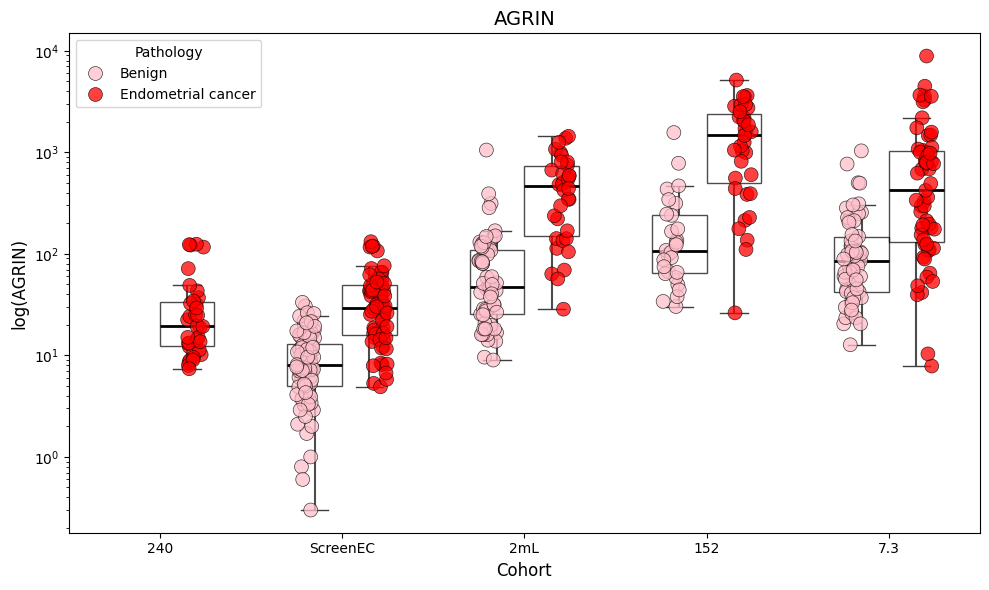

In [49]:
# Example usage for Endometrial_thickness
plot_variable_by_cohort_pathology(
    combined_df=combined_df,
    variable_name='AGRIN',
    y_label='log(AGRIN)',
    title='AGRIN',
    yscale='log'
)

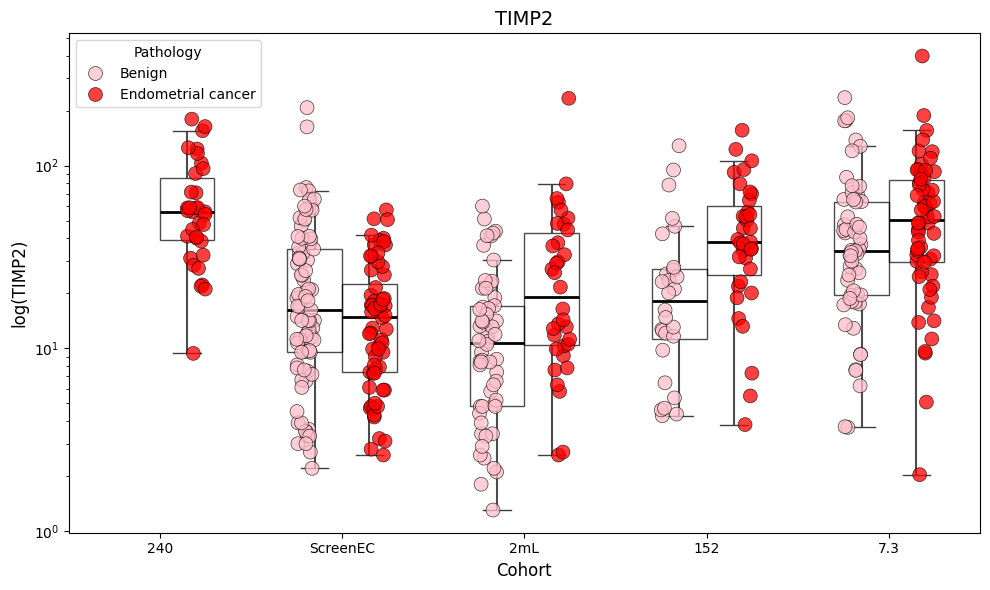

In [50]:
# Example usage for Endometrial_thickness
plot_variable_by_cohort_pathology(
    combined_df=combined_df,
    variable_name='TIMP2',
    y_label='log(TIMP2)',
    title='TIMP2',
    yscale='log'
)

In [51]:
df_152.columns

Index(['Pathology', 'AGRIN', 'TIMP2', 'KPYM', 'AGRIN_TIMP2_eps',
       'Endometrial_thickness', 'Pathology_pred', 'Pathology_pred_class',
       'Cohort'],
      dtype='object')

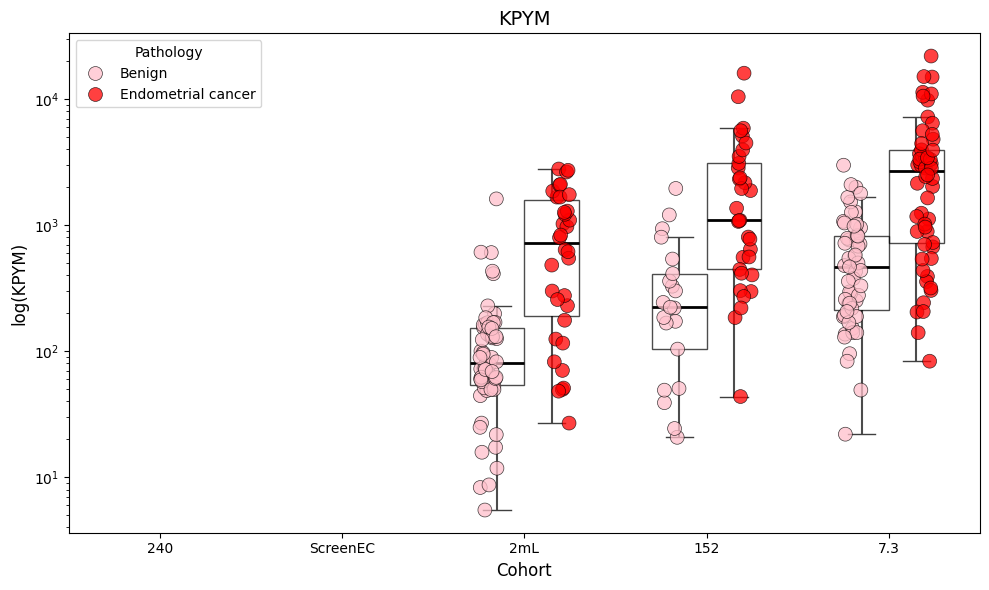

In [52]:
plot_variable_by_cohort_pathology(
    combined_df=combined_df,
    variable_name='KPYM',
    y_label='log(KPYM)',
    title='KPYM',
    yscale='log'
)

In [53]:
# Predict with model on df
X = sm.add_constant(df[['Endometrial_thickness', 'AGRIN_TIMP2_eps']], has_constant='add')
df_with_pred = df.copy()
df_with_pred['Pathology_pred'] = model.predict(X)



In [54]:
def plot_variable_by_cohort_pathology_with_outlier_labels(
    combined_df,
    variable_name,
    y_label,
    title,
    label_column=None,  # Column to use for labels, None defaults to index
    yscale='linear',
    figsize=(12, 8)
):
    """
    Plot a traditional boxplot showing outliers with smart label positioning and arrows.
    
    Args:
        combined_df: DataFrame containing the data
        variable_name: Name of the variable to plot
        y_label: Label for the y-axis
        title: Title for the plot
        label_column: Column to use for outlier labels (defaults to dataframe index if None or if column doesn't exist)
        yscale: Scale for the y-axis ('linear' or 'log')
        figsize: Size of the figure as a tuple (width, height)
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Check if label_column exists in DataFrame
    use_index_for_labels = True
    if label_column is not None and label_column in combined_df.columns:
        use_index_for_labels = False
    else:
        if label_column is not None:
            print(f"Warning: Column '{label_column}' not found in DataFrame. Using row indices for labels.")
        label_column = None
    
    # Create the boxplot with outliers shown
    boxplot = sns.boxplot(
        x="Pathology", 
        y=variable_name, 
        data=combined_df,
        palette=['pink', 'red'],  # Custom colors for pathology groups
        showfliers=True,  # Show outlier markers
        ax=ax
    )
    
    # Create a dictionary to track label positions per group to avoid overlaps
    used_positions = {}
    
    # Process each pathology group
    for i, pathology_group in enumerate(combined_df["Pathology"].unique()):
        # Initialize position tracking for this group
        used_positions[i] = []
        
        # Filter data for this pathology
        group_data = combined_df[combined_df["Pathology"] == pathology_group]
        
        # Calculate quartiles and IQR
        q1 = np.percentile(group_data[variable_name].dropna(), 25)
        q3 = np.percentile(group_data[variable_name].dropna(), 75)
        iqr = q3 - q1
        
        # Define outlier bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Find outliers
        outliers = group_data[(group_data[variable_name] < lower_bound) | 
                             (group_data[variable_name] > upper_bound)]
        
        # Add annotation for each outlier using its actual value
        for idx, row in outliers.iterrows():
            # Determine the label to use
            if not use_index_for_labels:
                label = str(row[label_column])
            else:
                label = str(idx)
            
            # Get the y value of this outlier
            y_coord = row[variable_name]
            
            # Position the label to the right of the point, avoiding overlaps
            offset_y = 0
            label_pos = (y_coord + offset_y)
            
            # Check for position overlap with existing labels
            while any(abs(pos - label_pos) < 0.05 * (upper_bound - lower_bound) for pos in used_positions[i]):
                offset_y += 0.05 * (upper_bound - lower_bound)  # Increase offset to avoid overlap
                label_pos = y_coord + offset_y
            
            # Save this label position
            used_positions[i].append(label_pos)
            
            # Add annotation with arrow connecting to data point
            ax.annotate(
                label,
                xy=(i, y_coord),  # Target point (the data point)
                xytext=(i + 0.3, label_pos),  # Position of text (offset to the right)
                fontsize=9,
                color='red',
                weight='bold',
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="arc3,rad=0.2",
                    color='red',
                    alpha=0.7,
                    linewidth=0.8
                )
            )
    
    plt.title(title, fontsize=16)
    plt.ylabel(y_label, fontsize=14)
    plt.xlabel('', fontsize=14)  # Hide the x-label as it's already clear from the plot
    
    if yscale == 'log':
        plt.yscale('log')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

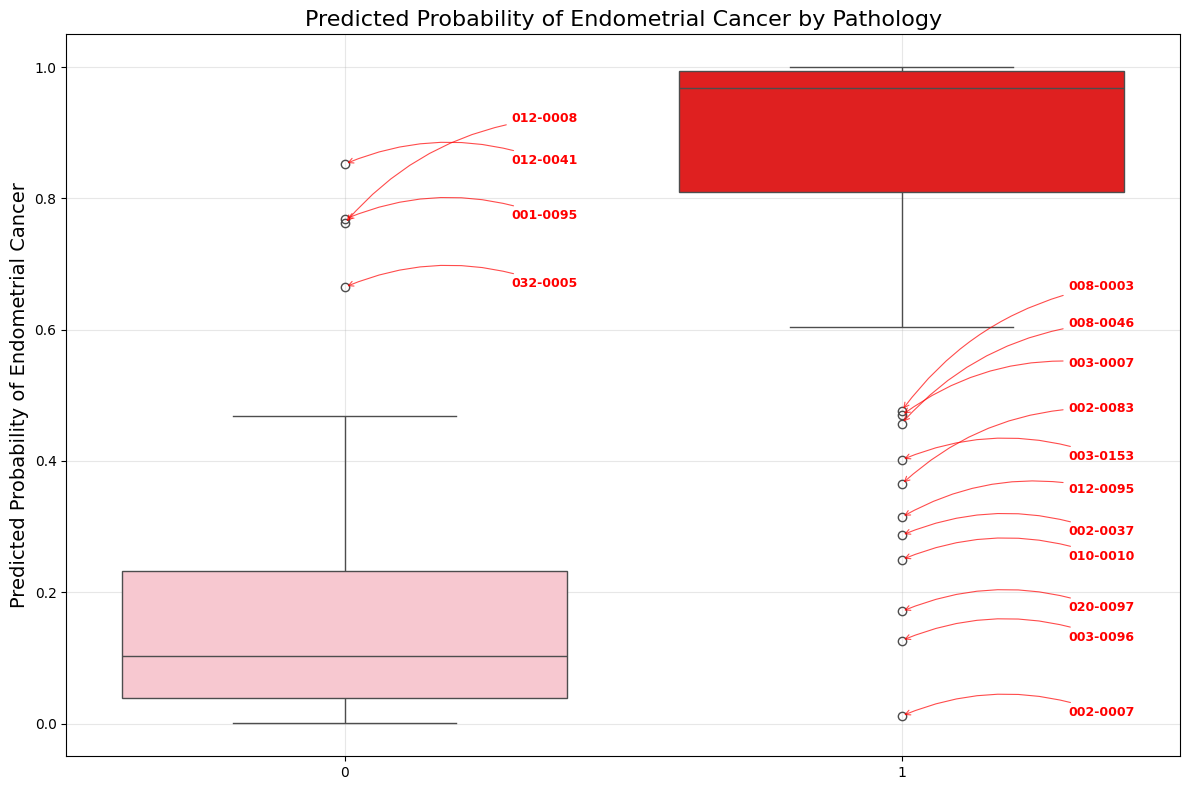

In [55]:
# Plot probabilities by pathology with labeled outliers - traditional boxplot style
plot_variable_by_cohort_pathology_with_outlier_labels(
    combined_df=df_with_pred,
    variable_name='Pathology_pred',
    y_label='Predicted Probability of Endometrial Cancer',
    title='Predicted Probability of Endometrial Cancer by Pathology',
    yscale='linear'
)

In [57]:
def analyze_prediction_outliers(
    df,
    pred_column='Pathology_pred',
    variables=['AGRIN', 'TIMP2', 'Endometrial_thickness', 'AGRIN_TIMP2_eps'],
    label_column=None,
    figsize=(10, 20)
):
    """
    Identify outliers in prediction column by pathology group, then analyze those samples across variables.
    
    Args:
        df: DataFrame containing the data
        pred_column: Prediction column to identify outliers
        variables: List of variables to analyze for the identified outliers
        label_column: Column to use for sample labels (defaults to index)
        figsize: Figure size as (width, height)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    from matplotlib import colors as colors_mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Check if label_column exists
    use_index_for_labels = True
    if label_column is not None and label_column in df.columns:
        use_index_for_labels = False
    else:
        if label_column is not None:
            print(f"Warning: Column '{label_column}' not found. Using row indices for labels.")
        label_column = None
    
    # First, identify outliers in prediction column by pathology group
    outlier_indices = []
    
    # Process each pathology group
    for pathology, group in df.groupby('Pathology'):
        if pred_column not in group.columns:
            print(f"Error: '{pred_column}' column not found in DataFrame.")
            return None
        
        # Calculate statistics for prediction column within this pathology group
        q1 = group[pred_column].quantile(0.25)
        q3 = group[pred_column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Find outliers within this pathology group
        outliers = group[(group[pred_column] < lower_bound) | (group[pred_column] > upper_bound)]
        
        # Add these indices to our master list
        outlier_indices.extend(outliers.index.tolist())
    
    # If no outliers found, exit
    if not outlier_indices:
        print(f"No outliers found in {pred_column} within pathology groups.")
        return None
    
    # Now analyze the specified variables for these outlier samples
    outlier_records = []
    
    # Filter dataframe to only include outlier samples
    outlier_samples = df.loc[outlier_indices]
    
    # For each variable, calculate z-scores based on the entire dataset
    for var in variables:
        if var not in df.columns:
            print(f"Warning: Variable '{var}' not in DataFrame. Skipping.")
            continue
        
        # Calculate mean and std for the whole dataset (not just outliers)
        var_mean = df[var].mean()
        var_std = df[var].std()
        
        # For each outlier sample, calculate its z-score for this variable
        for idx in outlier_indices:
            # Skip if this sample doesn't have data for this variable
            if pd.isna(df.loc[idx, var]):
                continue
                
            # Label for this record
            if not use_index_for_labels:
                label = str(df.loc[idx, label_column])
            else:
                label = str(idx)
            
            # Calculate z-score
            z_score = (df.loc[idx, var] - var_mean) / var_std
            
            # Also get the prediction outlier direction
            pred_mean = df.groupby('Pathology').get_group(df.loc[idx, 'Pathology'])[pred_column].mean()
            pred_direction = 'High' if df.loc[idx, pred_column] > pred_mean else 'Low'
            
            # Store record
            outlier_records.append({
                'Label': label,
                'Pathology': df.loc[idx, 'Pathology'],
                'Variable': var,
                'Value': df.loc[idx, var],
                'Z-score': z_score,
                'Direction': 'High' if z_score > 0 else 'Low',
                'Pred_Value': df.loc[idx, pred_column],
                'Pred_Direction': pred_direction
            })
    
    # Create a DataFrame with all outliers
    outlier_df = pd.DataFrame(outlier_records)
    
    # Create a figure with two subplots
    fig = plt.figure(figsize=figsize)
    
    # 1. First subplot: Scatter plot of z-scores
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
    
    # Define color map for pathology - ensure it handles all values
    colors = {'Benigna': 'royalblue', 'EC': 'crimson', 0: 'royalblue', 1: 'crimson'}
    markers = {'High': '^', 'Low': 'v'}
    
    # Create scatter plot grouped by pathology
    for pathology, path_group in outlier_df.groupby('Pathology'):
        for direction, dir_group in path_group.groupby('Direction'):
            # Get appropriate color, with fallback
            if pathology in colors:
                color = colors[pathology]
            else:
                color = 'gray'  # Default color if not found
                
            ax1.scatter(
                dir_group['Variable'], 
                dir_group['Z-score'],
                c=color,
                marker=markers[direction],
                s=100,
                alpha=0.7,
                label=f"{pathology} ({direction})"
            )
    
    # Add labels for each point
    for _, row in outlier_df.iterrows():
        ax1.annotate(
            row['Label'],
            xy=(row['Variable'], row['Z-score']),
            xytext=(5, 0),
            textcoords='offset points',
            fontsize=9,
            weight='bold'
        )
    
    # Add horizontal line at y=0 (the mean)
    ax1.axhline(y=0, color='green', linestyle='-', alpha=0.3, label='Mean')
    
    # Add horizontal lines at +/-2 and +/-3 standard deviations
    ax1.axhline(y=2, color='orange', linestyle='--', alpha=0.3, label='+2σ')
    ax1.axhline(y=-2, color='orange', linestyle='--', alpha=0.3)
    ax1.axhline(y=3, color='red', linestyle='--', alpha=0.3, label='+3σ')
    ax1.axhline(y=-3, color='red', linestyle='--', alpha=0.3)
    
    # Add labels and legend
    ax1.set_xlabel('Variable', fontsize=12)
    ax1.set_ylabel('Standard Deviations from Mean (Z-score)', fontsize=12)
    ax1.set_title(f'Variable Analysis for {pred_column} Outliers', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Create a legend with unique entries
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='best')
    
    # 2. Second subplot: Heatmap of outliers
    ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3, rowspan=1)
    
    # Pivot the data to create a matrix of z-scores (samples x variables)
    pivot_df = outlier_df.pivot_table(
        index=['Label', 'Pathology', 'Pred_Value', 'Pred_Direction'], 
        columns='Variable', 
        values='Z-score',
        aggfunc='mean'  # In case there are multiple entries
    ).fillna(0)  # Fill NaN with 0 (not an outlier in that variable)
    
    # Create a mask for NaN/0 values
    mask = np.zeros_like(pivot_df.values, dtype=bool)
    mask[pivot_df.values == 0] = True  # Mask non-outlier values
    
    # Sort samples by pathology and then by prediction value
    pivot_df = pivot_df.sort_values(['Pathology', 'Pred_Value'], ascending=[True, False])
    
    # Get pathology values for the color bar - FIXED THIS LINE
    pathologies = list(pivot_df.index.get_level_values('Pathology'))
    path_colors = [0 if p == 'Benigna' or p == 0 else 1 for p in pathologies]
    
    # Create heatmap for z-scores
    sns.heatmap(
        pivot_df, 
        cmap='RdBu_r',
        mask=mask,
        center=0,
        annot=True,
        fmt='.1f',
        linewidths=0.5,
        cbar_kws={'label': 'Z-score (std dev from mean)'},
        ax=ax2
    )
    
    # Add sample labels on y-axis
    y_labels = [f"{label} ({path}, {pred:.2f})" 
               for (label, path, pred, _) in pivot_df.index]
    ax2.set_yticklabels(y_labels, fontsize=9)
    
    # Add title for the heatmap
    ax2.set_title(f'Variable Z-scores for {pred_column} Outlier Samples', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Provide a table summary
    print(f"\nSummary of {len(outlier_indices)} outlier samples in {pred_column}:")
    summary_table = outlier_df.pivot_table(
        index=['Label', 'Pathology', 'Pred_Value', 'Pred_Direction'],
        columns='Variable',
        values='Value',
        aggfunc='first'
    ).reset_index()
    
    return summary_table

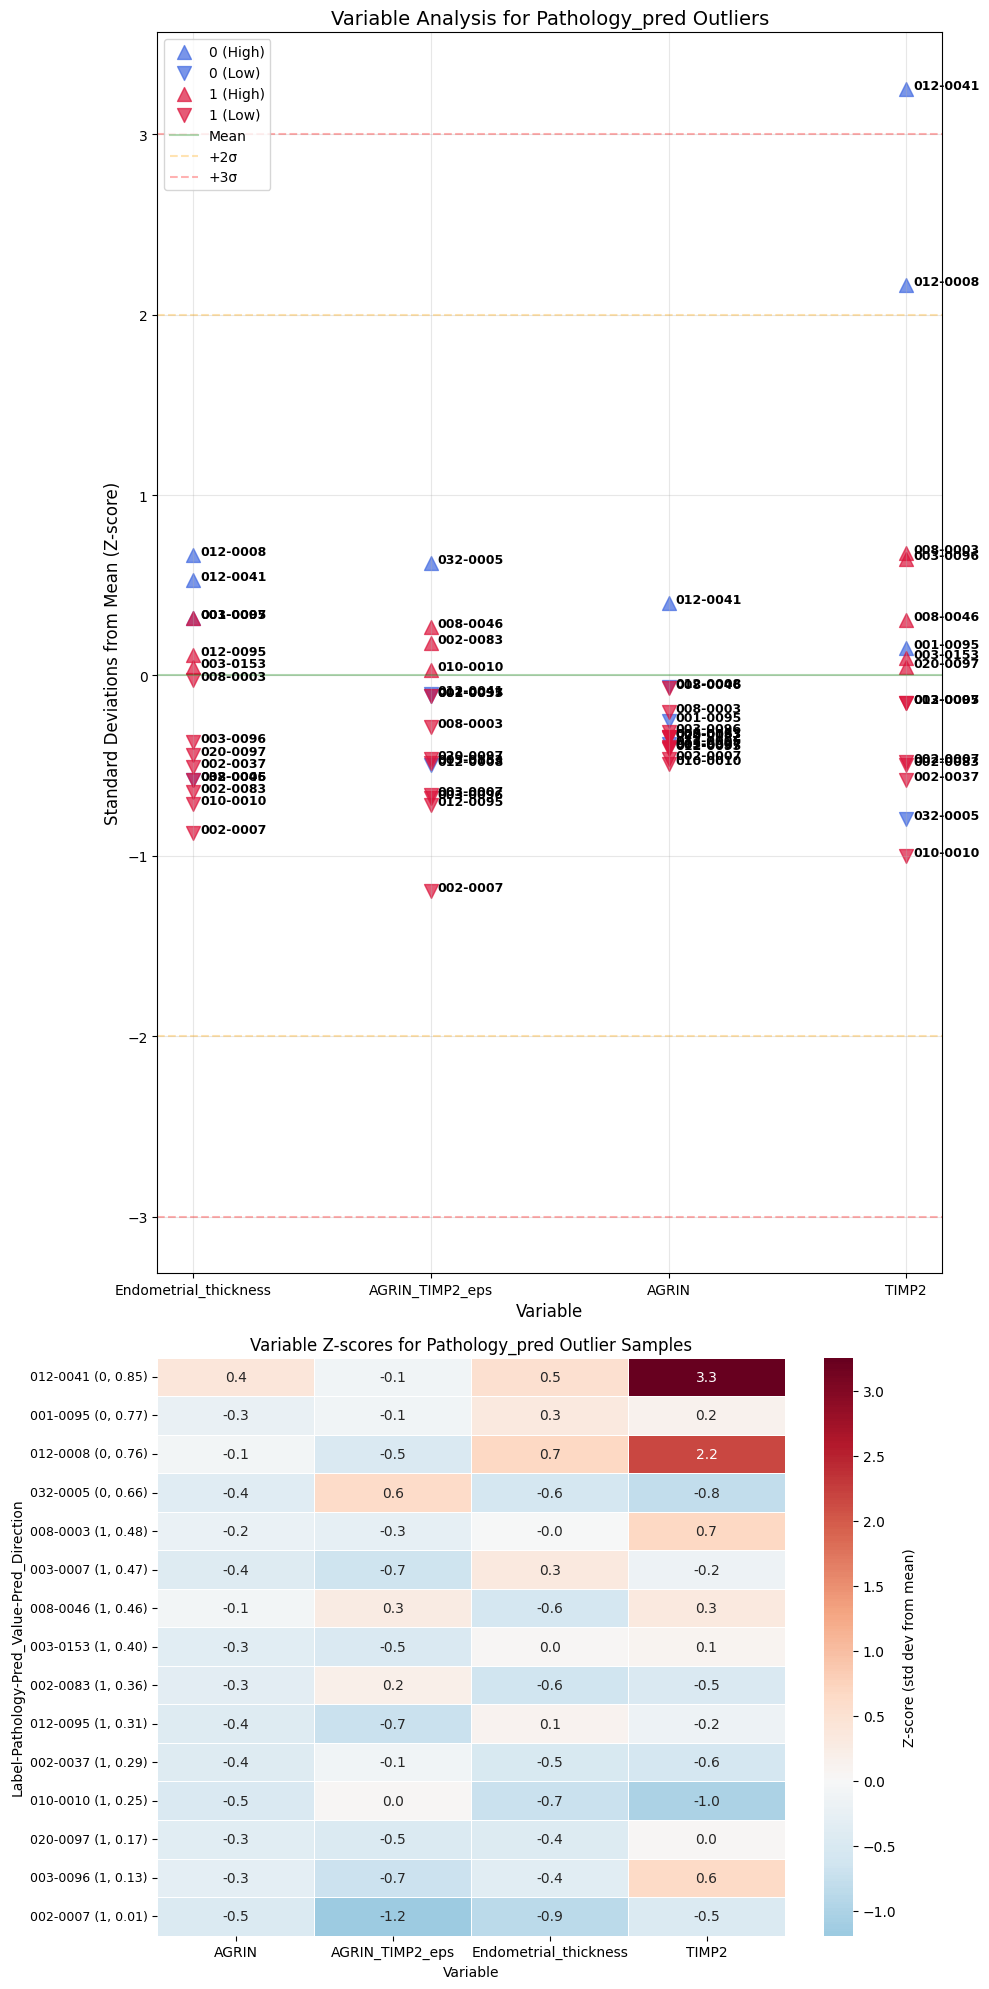


Summary of 15 outlier samples in Pathology_pred:


Variable,Label,Pathology,Pred_Value,Pred_Direction,AGRIN,AGRIN_TIMP2_eps,Endometrial_thickness,TIMP2
11,012-0041,0,0.852297,High,1032.803157,2.132667,24.0,235.516223
0,001-0095,0,0.768184,High,282.834580,2.115700,21.0,65.259451
10,012-0008,0,0.761948,High,496.328248,1.498037,26.0,175.717448
14,032-0005,0,0.664792,High,133.825814,3.315127,8.0,13.445821
7,008-0003,1,0.476308,Low,337.394283,1.839232,16.0,94.291764
4,003-0007,1,0.469436,Low,113.504804,1.226370,21.0,48.510975
8,008-0046,1,0.456933,Low,492.082696,2.737669,8.0,73.776403
6,003-0153,1,0.401621,Low,177.950345,1.515717,17.0,62.233258
3,002-0083,1,0.364552,Low,180.996474,2.598609,7.0,29.882085
12,012-0095,1,0.314347,Low,106.987993,1.140155,18.0,48.541604


In [58]:
# Analyze variables for samples that are outliers in prediction column
outlier_summary = analyze_prediction_outliers(
    df=df_with_pred,
    pred_column='Pathology_pred',
    variables=['Endometrial_thickness', 'AGRIN_TIMP2_eps', 'AGRIN', 'TIMP2'],
    label_column=None,  # Use row indices, or specify a column name if available
    #figsize=(8, 6)
)

# Display the outlier summary table
if outlier_summary is not None:
    display(outlier_summary.sort_values(by=['Pathology', 'Pred_Value'], ascending=[True, False]))